
*Pontifica Universidad Javeriana*

 *DPTO Ing Sistemas*

 **Materia** Procesamiento de Datos a Gran Escala

 **Autores:** Daniel Torres, Daniel Sandoval e Isaac Janica

**Fecha:**


In [0]:

# Se importan de las bibliotecas necesarias
import pyspark
from pyspark import SparkContext  #Importa la clase Spark context
from pyspark.sql import SQLContext, Row, Column #SqlContext permite poder hacer queries y operaciones con DataFrames de spark
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd

from pyspark.ml.feature import DenseVector, StandardScaler

import matplotlib.pyplot as plt

# File location and type
file_location = "/FileStore/tables/NYPD_Arrest_Data__Year_to_Date__20240301.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

df = spark.read.csv(file_location, header=first_row_is_header, inferSchema=infer_schema, sep=delimiter)
dfp = df.toPandas()
df.limit(4).toPandas()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,261265483,01/03/2023,397,"ROBBERY,OPEN AREA UNCLASSIFIED",105,ROBBERY,PL 1600500,F,B,49,0,18-24,M,BLACK,1027430,251104,40.855793,-73.843908,POINT (-73.843908 40.855793)
1,261271301,01/03/2023,105,STRANGULATION 1ST,106,FELONY ASSAULT,PL 1211200,F,S,120,0,25-44,M,WHITE,962808,174275,40.644996,-74.077263,POINT (-74.077263 40.644996)
2,261336449,01/04/2023,397,"ROBBERY,OPEN AREA UNCLASSIFIED",105,ROBBERY,PL 1601001,F,K,61,0,<18,M,BLACK,995118,155708,40.594054,-73.960866,POINT (-73.960866 40.594054)
3,261328047,01/04/2023,105,STRANGULATION 1ST,106,FELONY ASSAULT,PL 1211200,F,Q,114,0,18-24,M,BLACK,1007694,219656,40.769552,-73.915361,POINT (-73.915361 40.769552)


## **Colección y descripción de los datos:**
En este apartado se realiza la carga de los datos y se describen los datos según los siguientes elementos:
- Tamaño: número de columnas y de filas.
- Su tipo.
- Nombre.

Todo esto se puede ver más a fondo en el informe:
https://docs.google.com/document/d/1m7ay9uNr1dauOqrrx8NblZEC2QaYxdmR/edit?rtpof=true


### 'NombreColumna 'TipoDeDato':

In [0]:
df.dtypes

[('ARREST_KEY', 'string'),
 ('ARREST_DATE', 'string'),
 ('PD_CD', 'string'),
 ('PD_DESC', 'string'),
 ('KY_CD', 'string'),
 ('OFNS_DESC', 'string'),
 ('LAW_CODE', 'string'),
 ('LAW_CAT_CD', 'string'),
 ('ARREST_BORO', 'string'),
 ('ARREST_PRECINCT', 'string'),
 ('JURISDICTION_CODE', 'string'),
 ('AGE_GROUP', 'string'),
 ('PERP_SEX', 'string'),
 ('PERP_RACE', 'string'),
 ('X_COORD_CD', 'string'),
 ('Y_COORD_CD', 'string'),
 ('Latitude', 'string'),
 ('Longitude', 'string'),
 ('New Georeferenced Column', 'string')]

###Numero de Columnas y de Filas del DataSet:

In [0]:
print("Num columnas", len(df.columns))
print("Num filas", df.count())

Num columnas 19
Num filas 226872


### Conteo de nulos dentro del DataSet

In [0]:
# Print statement
print("Nulos por columna dentro del dataset de Collisions")

# Create a list to store the null counts
null_counts = []

# Iterate over each column to count null values
for col_name in df.columns:
    # Count the null values in the column
    null_count = df.select(col(col_name)).where(col(col_name).isNull()).count()
    # Append the null count to the list
    null_counts.append((col_name, null_count))

# Convert the null counts list to a PySpark DataFrame
null_counts_df = spark.createDataFrame(null_counts, ["Column Name", "Null Count"])

# Display the DataFrame
null_counts_df.show()

Nulos por columna dentro del dataset de Collisions
+--------------------+----------+
|         Column Name|Null Count|
+--------------------+----------+
|          ARREST_KEY|         0|
|         ARREST_DATE|         0|
|               PD_CD|         2|
|             PD_DESC|         0|
|               KY_CD|        17|
|           OFNS_DESC|         0|
|            LAW_CODE|         0|
|          LAW_CAT_CD|      1599|
|         ARREST_BORO|         0|
|     ARREST_PRECINCT|         0|
|   JURISDICTION_CODE|         0|
|           AGE_GROUP|         0|
|            PERP_SEX|         0|
|           PERP_RACE|         0|
|          X_COORD_CD|         0|
|          Y_COORD_CD|         0|
|            Latitude|         0|
|           Longitude|         0|
|New Georeferenced...|         0|
+--------------------+----------+



## Comprensión del significado de cada atributos:
En este caso, se hizo un diccionario de datos del cuál se tiene el siguiente link con el tipo de dato y la descripción de este:
https://docs.google.com/spreadsheets/d/1qxFz3B2A_1QBr87w9vNeHROOM842oU2F/edit#gid=1666817735


Lo diccionarios contienen el tipo de datos de cada atributo, a que hacen alusión y puede que en algunos casos, que columnas no se encuentran a pesar de que fueron parte de la misma tabla en el DBMS.

## **Descripción general del contenido de los conjuntos de datos:**


**Lo que se encontró en el conjunto de datos  fue:**
- El DataSet cuenta con 25 columnas y 4154748, un número bastante grande y que genera el tiempo de procesamiento de este sea mucho mayor que el DataSet de arrestos.
- Se cuenta con columnas como CRASH_DATE y CRASH_TIME que actualmente de tipo tiempo pero que pueden ser convertidas en en tipo Date y tipo Time. También hay otras variables en dónde estas son de tipo objeto pero podrían ser convertidas a variable de tipo numérico.
- Con una revisión a priori, el dataset presenta varias columnas con una enorme cantidad de nulos (hay columnas dónde el 50% o más de los registros son valores nulos).
- Este DataSet cuenta con 3 tipos diferentes de ID COLLISION_ID, UNIQUE_ID Y VEHICLE_ID. Dentro del diccionario de datos se explica que esto es debido a que esta tabla/DataSet es el resultado de un JOIN hecho entre dos tablas de una base de datos de la NYPD.
- Las columnas que no se entienden a priori son las de CONTRIBUTING_FACTOR.


# **Exploración de los datos:**

En ese apartado se proccede a hacer uso de estadística descriptiva para tener una idea general de los datos por columnas.
Se hará uso de histogramas, diagramas de pie y diagramas de líneas para poder graficar las diferentes variables. En el caso de las variables cualitativas se va a utilizar el diagrama de pie, en en el caso de las variables discretas se va a hacer uso diagramas de línea y de histogramas.

### Exploración de la columna 'OFNS_DESC' o en español

In [0]:
value_counts = dfp.groupby('OFNS_DESC').size()


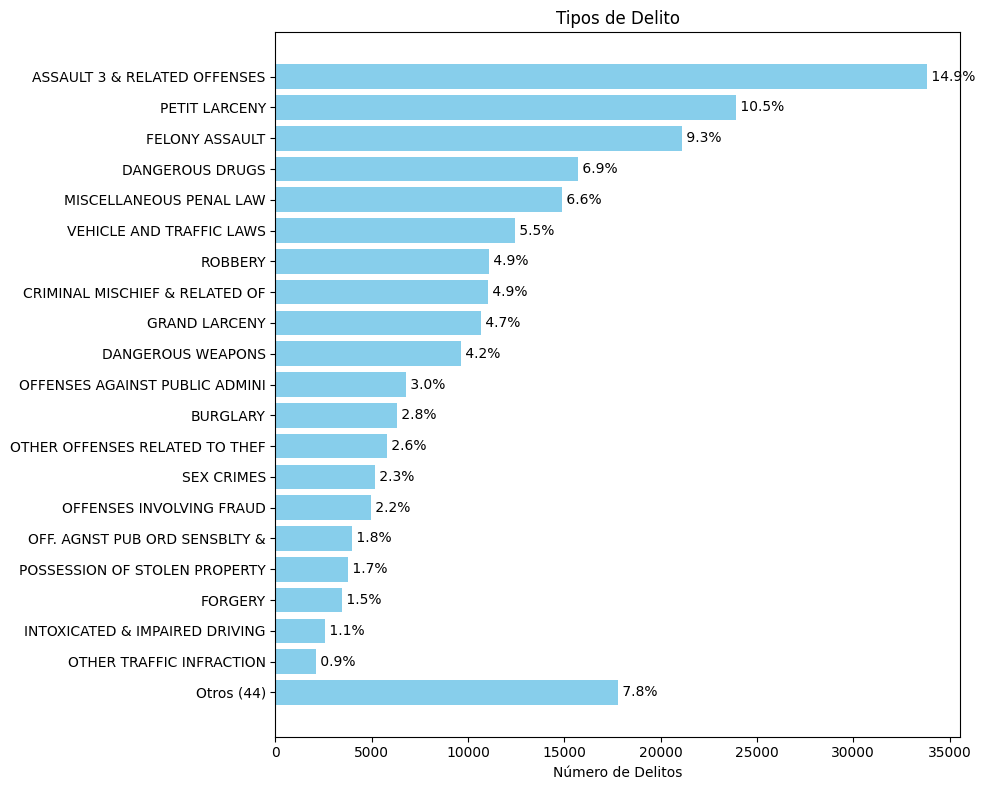

In [0]:

# Obtener los datos ordenados por frecuencia
sorted_counts = value_counts.sort_values(ascending=False)

# Obtener las 10 categorías más frecuentes
top_categories = sorted_counts.head(20)

# Sumar los conteos de las categorías que no están en las 10 más frecuentes y colocarlos en "Otros"
otros_count = sorted_counts[20:].sum()
top_categories[f'Otros ({len(sorted_counts[20:])})'] = otros_count

# Crear un gráfico de barras horizontales con las categorías organizadas de mayor a menor
plt.figure(figsize=(10, 8))  # Ajustar el tamaño de la figura según sea necesario
bars = plt.barh(top_categories.index, top_categories.values, color='skyblue')  # Gráfico de barras horizontal

plt.xlabel('Número de Delitos')  # Etiqueta del eje x
plt.title('Tipos de Delito')  # Título del gráfico
plt.gca().invert_yaxis()  # Invertir el eje y para que aparezcan los índices en orden descendente

# Mostrar los porcentajes en las barras
for bar in bars:
    yval = bar.get_height()  # Obtener la altura de la barra
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f' {bar.get_width() / sorted_counts.sum() * 100:.1f}%  ', 
             va='center')  # Mostrar el texto con el porcentaje

plt.tight_layout()  # Ajustar el diseño para evitar cortes
plt.show()

In [0]:

# plt.figure(figsize=(16, 14))  # Adjust the figure size as needed
# plt.pie(value_counts.values, labels=value_counts.index, autopct="%1.1f%%")  # Format as percentage
# plt.title("Tipo de Delito")
# plt.tight_layout()
# plt.show()

<Figure size 1400x800 with 0 Axes>

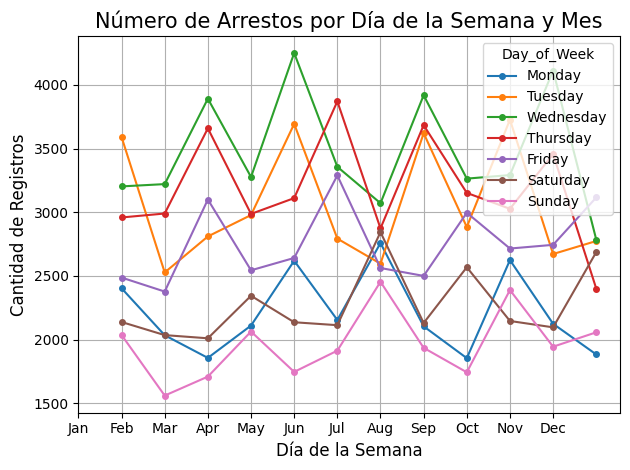

In [0]:
import calendar

# Convertir la columna de fecha a tipo datetime
dfp['ARREST_DATE'] = pd.to_datetime(dfp['ARREST_DATE'])

# Extraer el día de la semana y el mes
dfp['Day_of_Week'] = dfp['ARREST_DATE'].dt.day_name()
dfp['Month'] = dfp['ARREST_DATE'].dt.month

# Calcular el conteo de registros por día de la semana y mes
register_count = dfp.groupby(['Month', 'Day_of_Week']).size().unstack()

# Ordenar los días de la semana en orden lógico
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
register_count = register_count.reindex(columns=days_order)

# Graficar
plt.figure(figsize=(14, 8))  # Ajustar el tamaño de la figura según tus necesidades
register_count.plot(kind='line', marker='o', markersize=4, linestyle='-')  
plt.title('Número de Arrestos por Día de la Semana y Mes', fontsize=15)
plt.xlabel('Día de la Semana', fontsize=12)
plt.ylabel('Cantidad de Registros', fontsize=12)

# Etiquetas de los meses
month_labels = [calendar.month_name[i][:3] for i in range(1, 13)]
plt.xticks(ticks=range(12), labels=month_labels)  # Etiquetas de meses abreviadas

# Mostrar la cuadrícula
plt.grid(True)

# Ajustar el diseño
plt.tight_layout()

# Mostrar la visualización
plt.show()

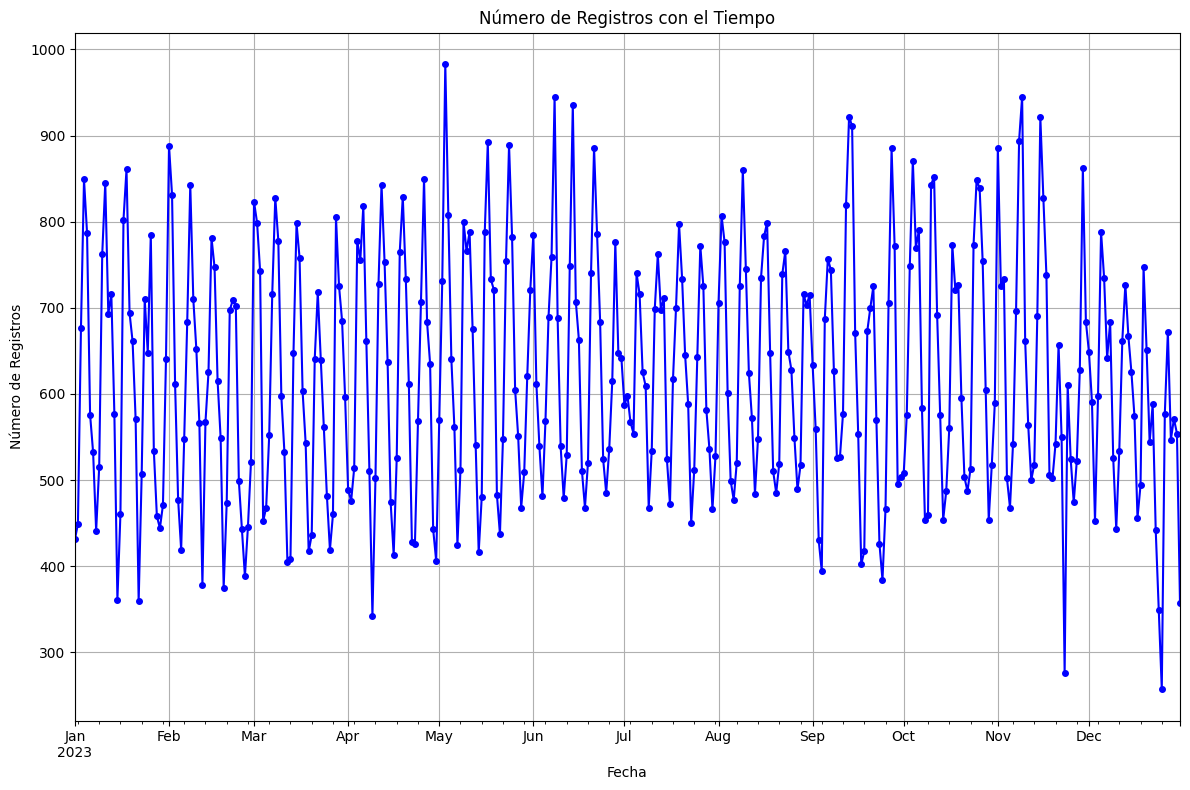

In [0]:
dfp['ARREST_DATE'] = pd.to_datetime(dfp['ARREST_DATE'])

# Agrupar por fecha y contar el número de registros por fecha
register_count = dfp.groupby('ARREST_DATE').size()

# Crear la visualización
plt.figure(figsize=(12, 8))  # Ajusta el tamaño según tus necesidades
register_count.plot(kind='line', color='blue', marker='o', markersize=4, linestyle='-')

# Añadir título y etiquetas de ejes
plt.title('Número de Registros con el Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Número de Registros')

# Ajustar los límites del eje x si es necesario
# plt.xlim(min_date, max_date)  # Establece los límites de fecha según tus datos

# Mostrar la cuadrícula
plt.grid(True)

# Ajustar el diseño
plt.tight_layout()

# Mostrar la visualización
plt.show()

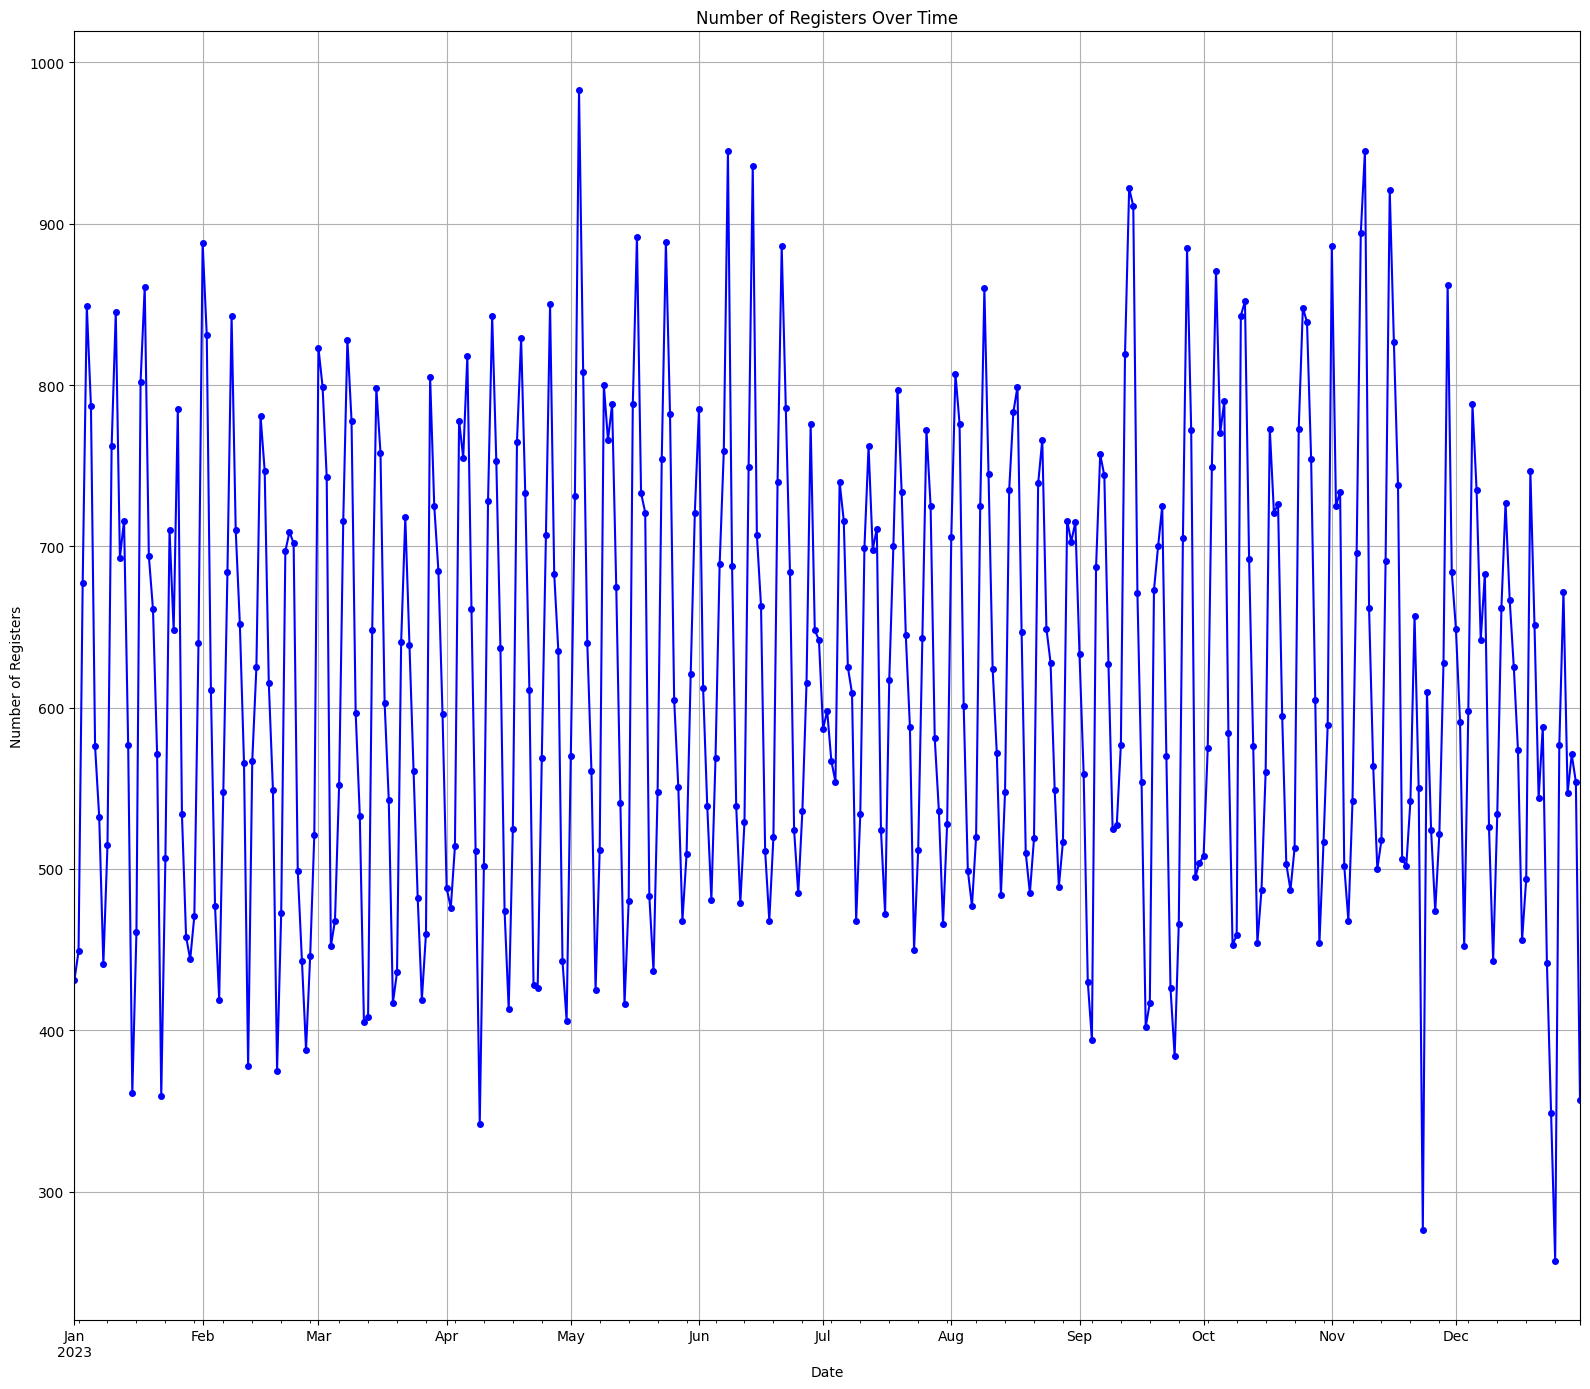

In [0]:
dfp['ARREST_DATE'] = pd.to_datetime(dfp['ARREST_DATE'])
register_count = dfp.groupby('ARREST_DATE').size()


plt.figure(figsize=(16, 14))
register_count.plot(kind='line', color='blue', marker='o', markersize=4, linestyle='-')
plt.title('Number of Registers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Registers')
plt.grid(True)
plt.tight_layout()
plt.show()

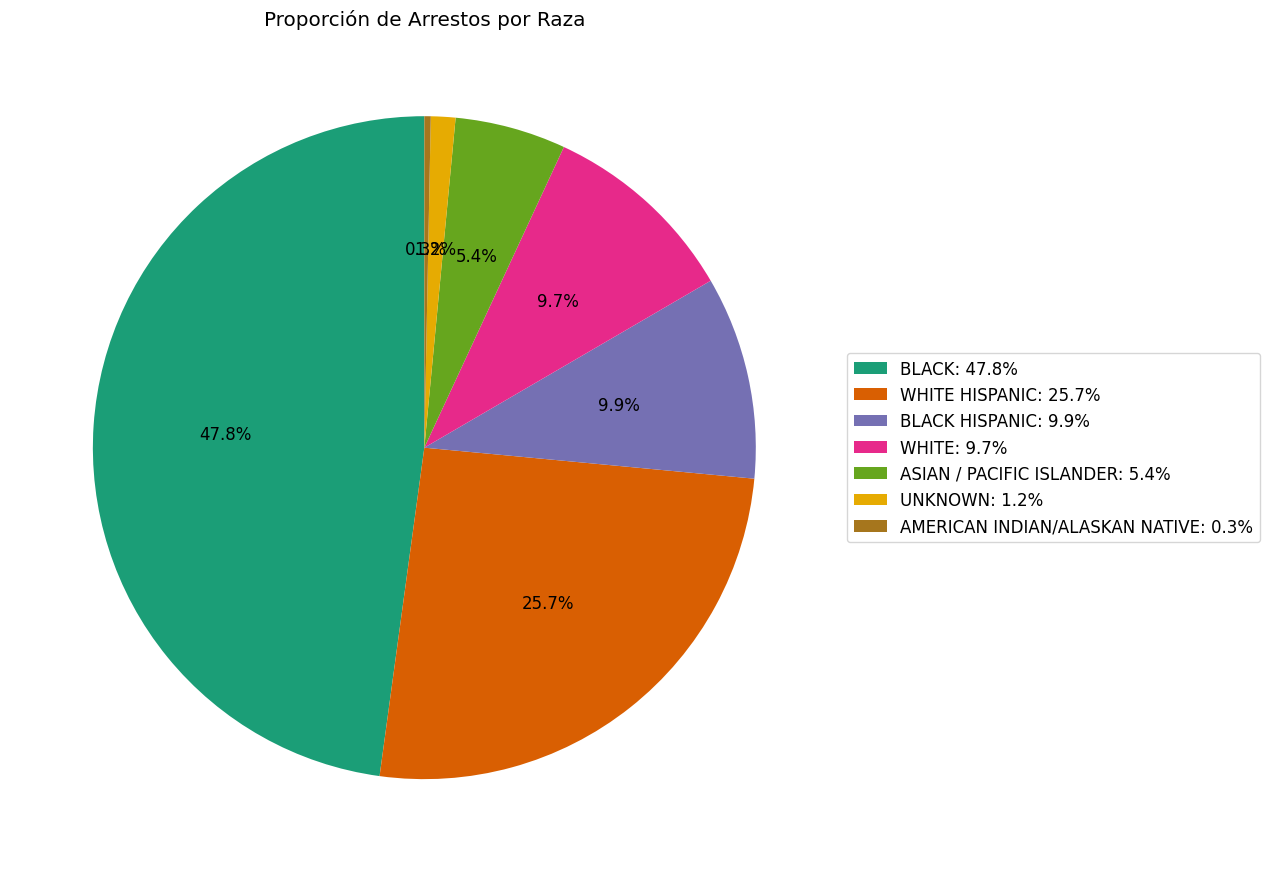

In [0]:
import matplotlib.pyplot as plt

# Agrupar por raza y contar arrestos
value_counts = dfp['PERP_RACE'].value_counts()

# Calcular porcentaje de cada categoría
percentages = 100 * value_counts / len(dfp)

# Ordenar los valores por cantidad de arrestos descendente
percentages = percentages.sort_values(ascending=False)

# Crear la figura y el gráfico
plt.figure(figsize=(12, 10))

# Definir una paleta de colores más oscura para las categorías más grandes
colors = plt.cm.Dark2.colors[:len(percentages)]

# Graficar el pastel con porcentajes y etiquetas
wedges, labels, autopct = plt.pie(percentages, labels=None, autopct="%1.1f%%", startangle=90, colors=colors)

# Configurar el tamaño de letra para los porcentajes dentro del pastel
for autotext in autopct:
    autotext.set_fontsize('large')  # Ajustar tamaño de letra a 'large'

# Añadir etiquetas fuera del pastel con nombres y porcentajes
label_texts = [f"{race}: {percentage:.1f}%" for race, percentage in zip(percentages.index, percentages)]
plt.legend(wedges, label_texts, loc="center left", fontsize='large', bbox_to_anchor=(1, 0, 0.5, 1))

# Añadir título
plt.title("Proporción de Arrestos por Raza", fontsize='x-large')

# Ajustar el diseño para que no se recorte la leyenda
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [0]:
# value_counts = dfp.groupby('PERP_RACE').size()

# plt.figure(figsize=(16, 14))  # Adjust the figure size as needed
# plt.pie(value_counts.values, labels=value_counts.index, autopct="%1.1f%%")  # Format as percentage
# plt.title("Delitos cometidos por raza")
# plt.tight_layout()
# plt.show()

In [0]:
# # Agrupar por género y contar delitos cometidos
# value_counts = dfp.groupby('PERP_SEX').size()

# # Calcular porcentaje de cada categoría
# percentages = 100 * value_counts / len(dfp)

# # Ordenar los valores por porcentaje descendente
# percentages = percentages.sort_values(ascending=False)

# # Crear la figura y el gráfico con tamaño ajustado
# plt.figure(figsize=(12, 10))

# # Definir una paleta de colores más oscura para las categorías más grandes
# colors = plt.cm.Dark2.colors[:len(percentages)]

# # Graficar el pastel con porcentajes y etiquetas
# wedges, labels, autopct = plt.pie(percentages, labels=None, autopct="%1.1f%%", startangle=90, colors=colors)

# # Configurar el tamaño de letra para los porcentajes dentro del pastel
# for autotext in autopct:
#     autotext.set_fontsize('large')  # Ajustar tamaño de letra a 'large'

# # Añadir etiquetas fuera del pastel con nombres y porcentajes
# label_texts = [f"{sex}: {percentage:.1f}%" for sex, percentage in zip(percentages.index, percentages)]
# plt.legend(wedges, label_texts, loc="center left", fontsize='large', bbox_to_anchor=(1, 0, 0.5, 1))

# # Añadir título
# plt.title("Delito por género", fontsize='x-large')

# # Ajustar el diseño para que no se recorte la leyenda
# plt.tight_layout()

# # Mostrar el gráfico
# plt.show()

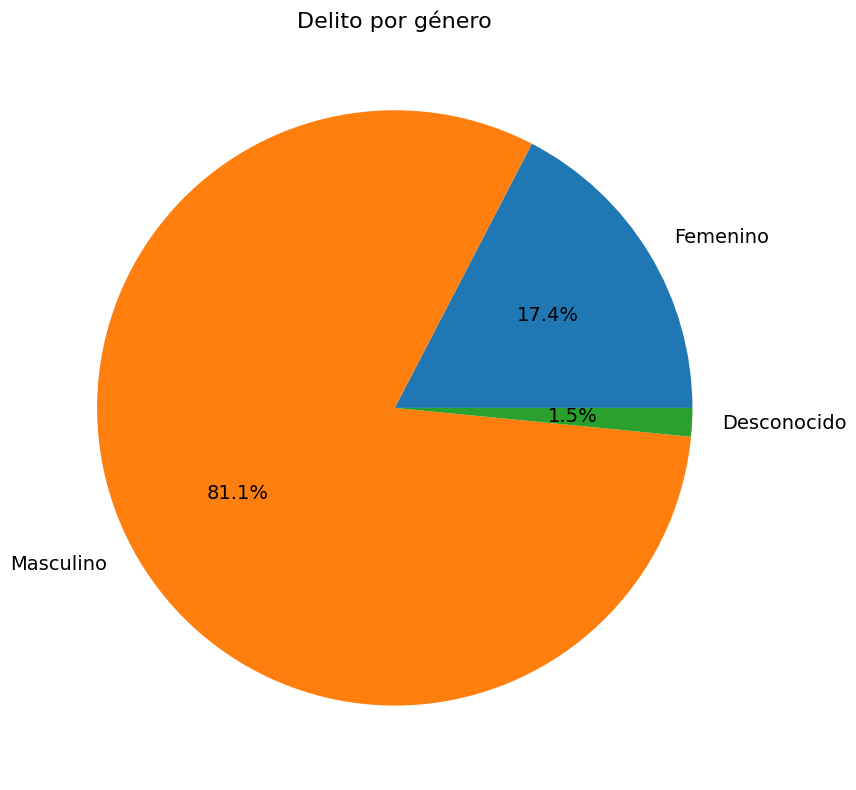

In [0]:
# Calcular value_counts para PERP_SEX
value_counts = dfp.groupby('PERP_SEX').size()

# Renombrar las etiquetas según tus especificaciones
gender_labels = {'F': 'Femenino', 'M': 'Masculino', 'U': 'Desconocido'}
labels = [gender_labels.get(label, label) for label in value_counts.index]

# Configurar el tamaño del gráfico y otros parámetros
plt.figure(figsize=(10, 8))  # Ajustar el tamaño según sea necesario
plt.pie(value_counts.values, labels=labels, autopct="%1.1f%%", textprops={'fontsize': 14})  # Ajustar el tamaño del texto
plt.title("Delito por género", fontsize=16)  # Ajustar el título
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [0]:
# value_counts = dfp.groupby('PERP_SEX').size()

# plt.figure(figsize=(16, 14))  # Adjust the figure size as needed
# plt.pie(value_counts.values, labels=value_counts.index, autopct="%1.1f%%")  # Format as percentage
# plt.title("Delito por género")
# plt.tight_layout()
# plt.show()

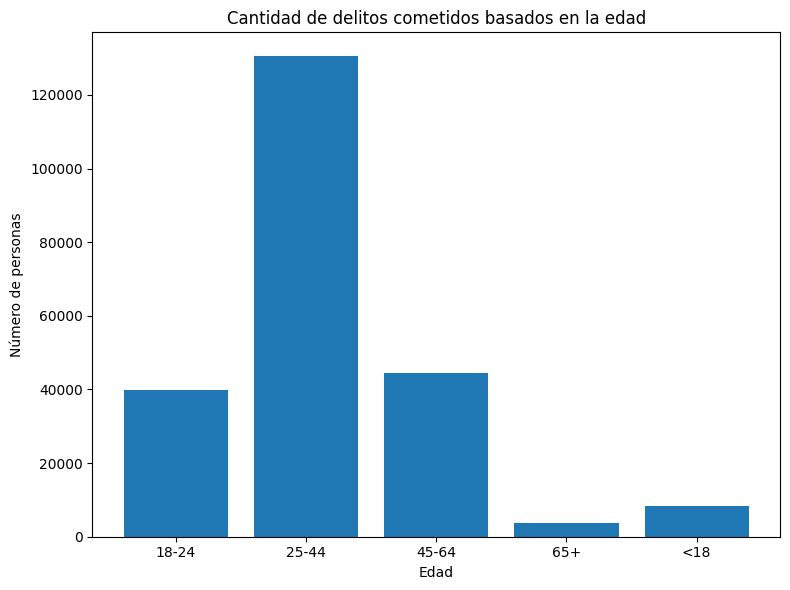

In [0]:

# Get the value counts
value_counts = dfp.groupby("AGE_GROUP").size()

# Create the bar chart
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.bar(value_counts.index, value_counts.values)
plt.xlabel("Edad")  
plt.ylabel("Número de personas")
plt.title("Cantidad de delitos cometidos basados en la edad")
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Limpieza de Datos


### Inputación de datos en la columnas 'KY_CD' basado en valores de la columna 'PD_CD'

En este apartado se crea un diccionario en dónde se va a almacenar los valores equivalente de PD_CD para KY_CD debido a que esta última columna cuenta con más valores nulos que la primera. Con esto se espera que al momento de haber un nulo en KY_CD, este sea rellenado usando un diccionario que almacena una "tabla de equivalencias" entre los valores de PD_CD y KY_CD. Por ejemplo digamos que el diccionario alamcena que {101: 304, 102: 702} y encuentra que el valor en KY_CD es nulo pero que en PC_CD es 101, entonces va a reemplazar el valor faltante por 304. 

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, udf
from pyspark.sql.types import *


# Assuming you have a DataFrame named 'df' with columns 'PD_CD' and 'KY_CD'
# Replace 'PD_CD' and 'KY_CD' with the actual names of your columns

# Collect distinct pairs of (PD_CD, KY_CD) where they are not necessarily equal but represent corresponding values
pairs = df.select("PD_CD", "KY_CD").distinct().filter(df.PD_CD.isNotNull() & df.KY_CD.isNotNull()).collect()

# Construct a dictionary to store the relations
relations_dict = {}
for row in pairs:
    pd_cd = row["PD_CD"]
    ky_cd = row["KY_CD"]
    if pd_cd not in relations_dict:
        relations_dict[pd_cd] = []
    relations_dict[pd_cd].append(ky_cd)

# Print the dictionary
print("Relations:")
for pd_cd, ky_cd_list in relations_dict.items():
    print(f"PD_CD: {pd_cd} -> KY_CDs: {ky_cd_list}")

def fill_null_with_dict(value, relations_dict):
    return relations_dict.get(value, value)

fill_null_with_dict_udf = udf(lambda x: fill_null_with_dict(x, relations_dict), StringType())


df_filled = df.withColumn("KY_CD", when(col("KY_CD").isNull(), fill_null_with_dict_udf(col("PD_CD"))).otherwise(col("KY_CD")))

nulls_count_ky_cd = df_filled.filter(col("KY_CD").isNull()).count()

# Print the count
print("Number of null values in KY_CD:", nulls_count_ky_cd)




Relations:
PD_CD: 511 -> KY_CDs: ['235']
PD_CD: 129 -> KY_CDs: ['101']
PD_CD: 183 -> KY_CDs: ['124']
PD_CD: 514 -> KY_CDs: ['117']
PD_CD: 409 -> KY_CDs: ['109']
PD_CD: 117 -> KY_CDs: ['126']
PD_CD: 185 -> KY_CDs: ['124']
PD_CD: 696 -> KY_CDs: ['126']
PD_CD: 969 -> KY_CDs: ['881']
PD_CD: 638 -> KY_CDs: ['578']
PD_CD: 173 -> KY_CDs: ['233']
PD_CD: 157 -> KY_CDs: ['104']
PD_CD: 289 -> KY_CDs: ['354']
PD_CD: 198 -> KY_CDs: ['126']
PD_CD: 505 -> KY_CDs: ['117']
PD_CD: 727 -> KY_CDs: ['113']
PD_CD: 799 -> KY_CDs: ['363']
PD_CD: 125 -> KY_CDs: ['103']
PD_CD: 705 -> KY_CDs: ['358']
PD_CD: 645 -> KY_CDs: ['351']
PD_CD: 439 -> KY_CDs: ['109']
PD_CD: 519 -> KY_CDs: ['117']
PD_CD: 441 -> KY_CDs: ['110']
PD_CD: 16 -> KY_CDs: ['995']
PD_CD: 563 -> KY_CDs: ['356']
PD_CD: 772 -> KY_CDs: ['112']
PD_CD: 476 -> KY_CDs: ['343']
PD_CD: 939 -> KY_CDs: ['881']
PD_CD: 792 -> KY_CDs: ['118']
PD_CD: 268 -> KY_CDs: ['121']
PD_CD: 750 -> KY_CDs: ['359']
PD_CD: 523 -> KY_CDs: ['117']
PD_CD: 904 -> KY_CDs: ['119']


### Eliminación de columnas
Se van a eliminar las columnas: ARREST_KEY, LAW_CODE, JURISDICTION_CODE, New Georeferenced Column, LAW_CAT_CD y KY_CD

In [0]:
#se va eliminar la columa de KY_CD porque PD_CD ya contiene esos datos en otro formato

df_filled = df_filled.drop("KY_CD")

# También se van a eliminar las columa ARREST_KEY, LAW_CODE, JURISDICTION_CODE, New Georeferenced Column  y LAW_CAT_CD porque no aporta nada para el ejercicio de análisis

df_filled = df_filled.drop("ARREST_KEY")
df_filled = df_filled.drop("LAW_CODE")
df_filled = df_filled.drop("JURISDICTION_CODE")
df_filled = df_filled.drop('New Georeferenced Column')
df_filled = df_filled.drop('LAW_CAT_CD')


df_filled.limit(4).toPandas()



,ARREST_DATE,PD_CD,PD_DESC,OFNS_DESC,ARREST_BORO,ARREST_PRECINCT,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,01/03/2023,397,"ROBBERY,OPEN AREA UNCLASSIFIED",ROBBERY,B,49,18-24,M,BLACK,1027430,251104,40.855793,-73.843908
1,01/03/2023,105,STRANGULATION 1ST,FELONY ASSAULT,S,120,25-44,M,WHITE,962808,174275,40.644996,-74.077263
2,01/04/2023,397,"ROBBERY,OPEN AREA UNCLASSIFIED",ROBBERY,K,61,<18,M,BLACK,995118,155708,40.594054,-73.960866
3,01/04/2023,105,STRANGULATION 1ST,FELONY ASSAULT,Q,114,18-24,M,BLACK,1007694,219656,40.769552,-73.915361


###Estandarización de la fecha: 

In [0]:
#Convertir la fecha de arresto de tipo string a tipo fecha

df = df.withColumn('ARREST_DATE', to_date(df['ARREST_DATE'], 'MM/dd/yyyy'))
df.dtypes

[('ARREST_KEY', 'string'),
 ('ARREST_DATE', 'date'),
 ('PD_CD', 'string'),
 ('PD_DESC', 'string'),
 ('KY_CD', 'string'),
 ('OFNS_DESC', 'string'),
 ('LAW_CODE', 'string'),
 ('LAW_CAT_CD', 'string'),
 ('ARREST_BORO', 'string'),
 ('ARREST_PRECINCT', 'string'),
 ('JURISDICTION_CODE', 'string'),
 ('AGE_GROUP', 'string'),
 ('PERP_SEX', 'string'),
 ('PERP_RACE', 'string'),
 ('X_COORD_CD', 'string'),
 ('Y_COORD_CD', 'string'),
 ('Latitude', 'string'),
 ('Longitude', 'string'),
 ('New Georeferenced Column', 'string')]

In [0]:
# Create a view or table
#%sql
#/* Query the created temp table in a SQL cell */

#select * from `NYPD_Arrest_Data__Year_to_Date__20240301_csv`

#temp_table_name = "NYPD_Arrest_Data__Year_to_Date__20240301_csv"

#df.createOrReplaceTempView(temp_table_name)
#df


# With this registered as a temp view, it will only be available to this particular notebook. If you'd like other users to be able to query this table, you can also create a table from the DataFrame.
# Once saved, this table will persist across cluster restarts as well as allow various users across different notebooks to query this data.
# To do so, choose your table name and uncomment the bottom line.

#permanent_table_name = "NYPD_Arrest_Data__Year_to_Date__20240301_csv"

# df.write.format("parquet").saveAsTable(permanent_table_name)